In [33]:
import os
# change the path to the root of the project directory if not in "project-5" directory
while os.path.basename(os.getcwd()) != "project-5":
    os.chdir("..")
print(f"Current working directory: {os.getcwd()}")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import datetime

from src.utils.model_runner import evaluate_models, evaluate_models_nested, plot_roc_curves, plot_precision_recall_curves, plot_classification_metric
from src.utils.preprocess import GeneExpPreprocessor, generateFeatureSpace
from src.utils.data_handler import DataHandler
from sklearn.feature_selection import SelectKBest, f_classif

DH = DataHandler()

Current working directory: /home/chris/code/ucsd/beng285/breast-cancer-team-1/project-5


<h1>Load GE and PFS</h1>

In [63]:
n_stage_grouped = {
    'NX': 0,
    'N0': 0,
    'N0 (I-)': 0,
    
    'N0 (I+)': 1,
    'N0 (MOL+)': 1,
    'N1MI': 1,
    
    'N1': 2,
    'N1A': 2,
    'N1B': 2,
    'N1C': 2,
    
    'N2': 3,
    'N2A': 3,
    
    'N3': 4,
    'N3A': 4,
    'N3B': 4,
    'N3C': 4
}

In [64]:
features = generateFeatureSpace()
features.set_index(['patient_id','sample_id'], inplace=True)
features.drop(columns=['Patient ID', 'Sample ID','PFI_over60mo'], inplace=True)

metadata = pd.read_csv('data/raw/brca_tcga_pan_can_atlas_2018_clinical_data_PAM50_subype_and_progression_free_survival.tsv', sep='\t', index_col=[1,2])
metadata['stage'] = metadata['Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code'].map(n_stage_grouped)
dfm = metadata['Disease Free (Months)']
dfs = metadata['Disease Free Status']
dfs = dfs.dropna()
dfm = dfm.dropna()
diseased = (dfm < 60) & (dfs == '1:Recurred/Progressed')

n_patients = features.index.nunique()
n_samples = features.shape[0]
print(f"There are {n_patients} patients and {n_samples} samples in the dataset.")

generating initial feature space....
Number of rows with all NA in mutation columns (before): 352
Number of rows with all NA in mutation columns (after): 0
Adding latent dims to feature space...
data/raw/latent_space_5dim_BRCA_Normal.csv
data/raw/latent_space_5dim_BRCA_Her2.csv
data/raw/latent_space_5dim_BRCA_LumA.csv
data/raw/latent_space_5dim_BRCA_LumB.csv
data/raw/latent_space_5dim_BRCA_Basal.csv
There are 1073 patients and 1073 samples in the dataset.


Loaded matrix with 1132 samples x 20531 genes
Parsing gencode fasta file: data/raw/gencode.v23lift37.pc_transcripts.fa
Finding longest CDS length for each gene
Normalizing expression data to log1p(TPM)
Filtering out lowly expressed genes with mean expression of 1
Filtering out lowest 50.0% of genes
Subsetting to top 1000 genes using method: dndscv


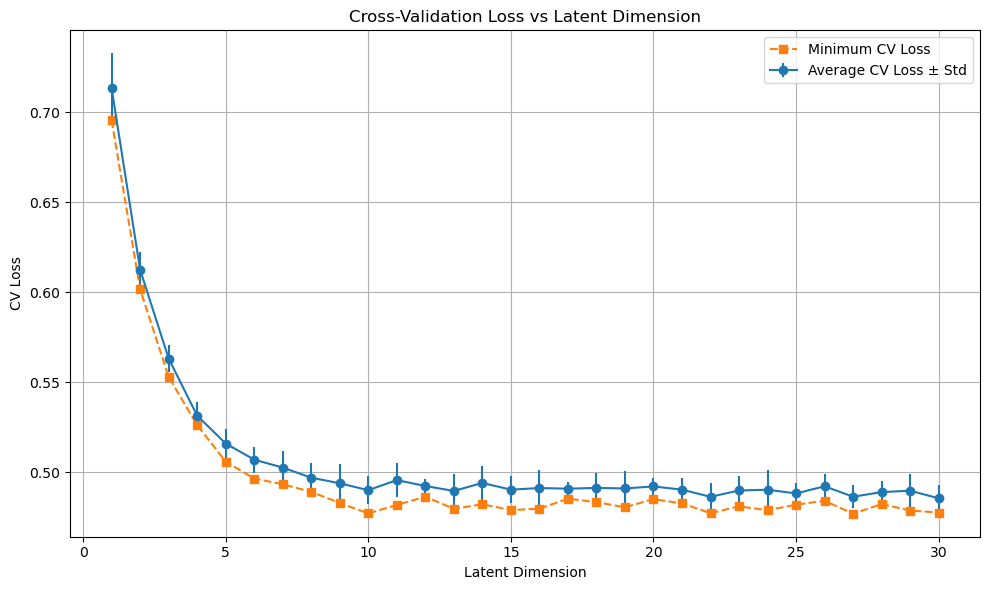

In [65]:
geneExpParams = {
    'top_N': 1000,
    'subset_method': 'dndscv'    # method to subset genes {dndscv, variance}
}

all_exp = GeneExpPreprocessor(**geneExpParams, filter_subtypes=False, save=False).get_df()

with open("/home/chris/code/ucsd/beng285/breast-cancer-team-1/project-5/data/processed/optimal_latent_0607_20-30_no_model_state.pkl", "rb") as f:
    results = pickle.load(f)

losses = pd.read_csv('/home/chris/code/ucsd/beng285/breast-cancer-team-1/project-5/data/processed/optimal_latent_cv_losses_0607_20-30.csv')

plt.figure(figsize=(10, 6))
plt.errorbar(losses["latent_dim"], losses["avg_cv_loss"], yerr=losses["std_cv_loss"], label="Average CV Loss ± Std", fmt='-o')
plt.plot(losses["latent_dim"], losses["min_cv_loss"], label="Minimum CV Loss", marker='s', linestyle='--')

plt.xlabel("Latent Dimension")
plt.ylabel("CV Loss")
plt.title("Cross-Validation Loss vs Latent Dimension")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [66]:
latent = results[10]['latent_space']
df_latent = pd.DataFrame(latent, index=all_exp.index, columns=[f"latent_{i+1}" for i in range(latent.shape[1])])

n_patients = df_latent.index.get_level_values("patient_id").nunique()
n_samples = df_latent.index.get_level_values("sample_id").nunique()
print(f"There are {n_patients} patients and {n_samples} samples in the dataset.")

There are 1018 patients and 1132 samples in the dataset.


<h1>Align indices for df_exp and PFS</h2>

In [67]:
df = df_latent.copy()

def truncate_sample_id(s):
    parts = s.split('-')
    if len(parts) >= 4:
        return '-'.join(parts[:4])[:-1]
    else:
        return s

new_index = df.index.set_levels(
    df.index.levels[1].map(truncate_sample_id),
    level=1
)

df.index = new_index

In [68]:
new_index = features.index.set_levels(
    features.index.levels[1].map(truncate_sample_id),
    level=1
)

features.index = new_index

In [69]:
df = pd.merge(df, features.iloc[:,:-5], left_index=True, right_index=True)

<h1>Generate X and y</h1>

In [72]:
X = df.copy()

# get intersection of samples in X and pfs
intersection_samples = X.index.intersection(diseased.index)
print(f"Number of samples in intersection: {len(intersection_samples)}")

# filter to keep only samples in the intersection
X = X.loc[intersection_samples]
diseased = diseased.loc[intersection_samples]

X = X.reset_index().drop(columns=['sample_id']).set_index('patient_id')
diseased = diseased.reset_index().drop(columns=['Sample ID']).set_index('Patient ID')

# get bool of whether pfs is greater than 5 years
y = list(diseased[0])

Number of samples in intersection: 842


In [75]:
mutations = pd.read_csv('data/raw/TCGA.BRCA.mutations.txt', sep="\t")

non_synonymous_mutations = mutations[~mutations["Variant_Classification"].isin(["Silent", "Intron", "3'Flank", "3'UTR", "5'UTR"]) & (mutations["FILTER"] == "PASS")]
# ACTN4 + HIST1H3B + ITPR2 + MSH5
filter_genes = ["BRCA1","BRCA2","ACTN4", "HIST1H3B", "ITPR2", "MSH5"]
# coutn the number of non-synonymous mutations in the filter genes for each sample
mutation_count = non_synonymous_mutations[non_synonymous_mutations["Hugo_Symbol"].isin(filter_genes)].groupby(['patient_id','Hugo_Symbol']).size().unstack(fill_value=0)
mutation_count['BRCA'] = mutation_count['BRCA1'] + mutation_count['BRCA2'] > 0

In [76]:
X = pd.merge(X, mutation_count, left_index=True, right_index=True, how='left')
X = X.fillna(0)
X.shape

(842, 31)

In [77]:
X.describe()

,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,latent_10,...,MAP3K1,PIK3CA,PTEN,TP53,ACTN4,BRCA1,BRCA2,HIST1H3B,ITPR2,MSH5
count,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,...,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000
mean,-1.931509,-6.741899,-0.203169,1.028175,1.204546,1.400685,-6.395519,-1.259581,1.438808,-0.179474,...,0.092637,0.308789,0.047506,0.285036,0.009501,0.022565,0.021378,0.011876,0.013064,0.009501
std,10.425834,8.440175,10.580449,8.723334,6.835703,10.432718,8.724542,11.352881,9.547763,11.987668,...,0.391306,0.538323,0.228992,0.464675,0.097068,0.148601,0.152721,0.108395,0.141574,0.097068
min,-53.124748,-42.201256,-45.316982,-35.566669,-22.596670,-26.635115,-54.059540,-58.497490,-30.510334,-42.214031,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.818954,-10.993144,-4.954003,-3.020367,-2.763350,-4.798413,-10.150202,-6.611054,-3.806520,-5.665054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.317092,-4.556097,0.646261,1.334094,0.496138,-0.373275,-4.371579,-1.005149,0.852368,0.593572,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.364739,-0.927586,5.148742,5.578298,4.458863,4.962995,-1.131219,4.705129,6.439187,6.042044,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,24.992592,17.586969,42.226379,34.739296,33.935551,45.087276,17.605192,40.628284,36.614799,54.386345,...,4.000000,3.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000


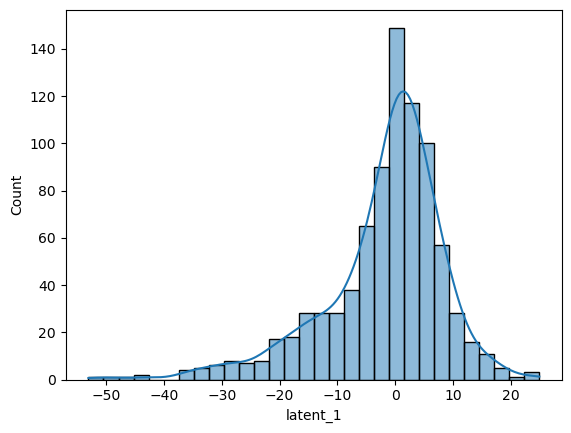

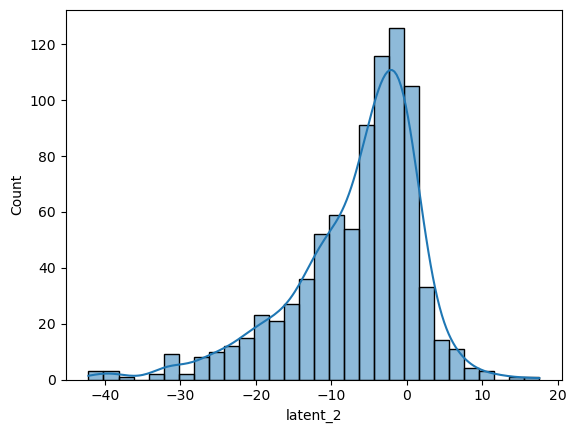

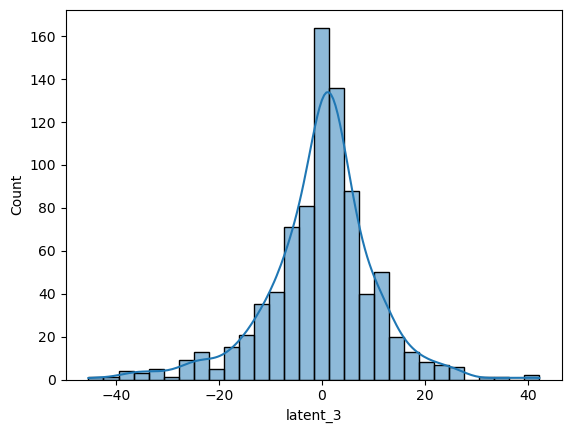

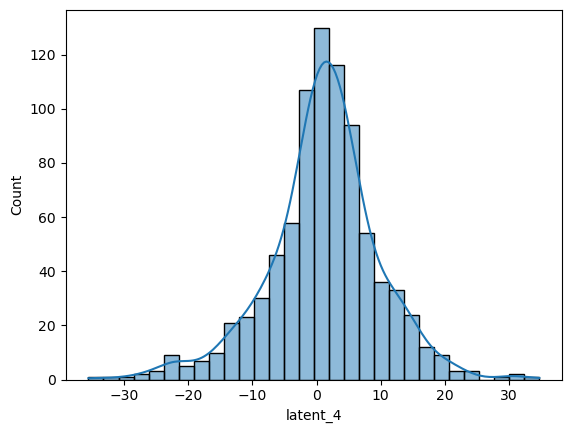

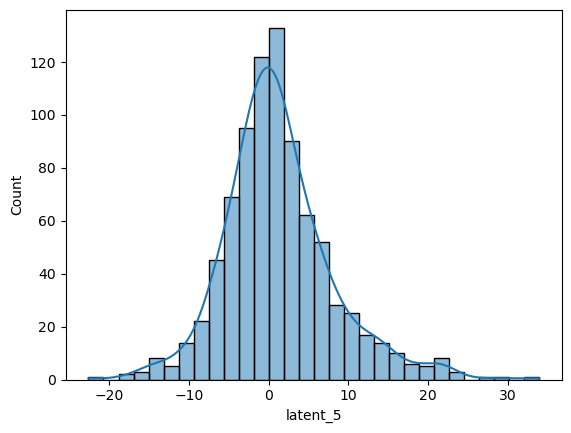

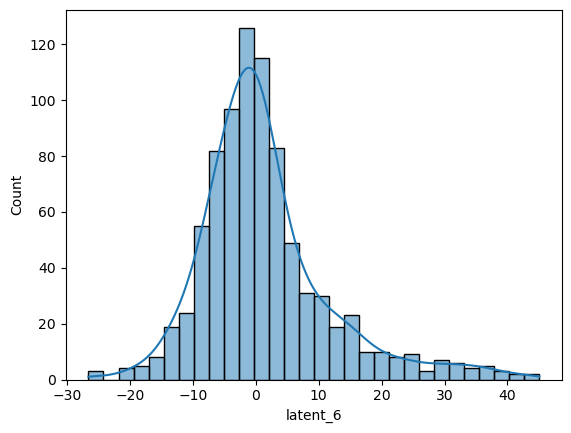

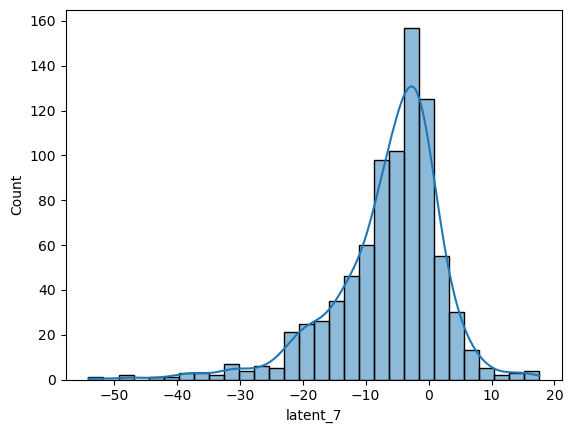

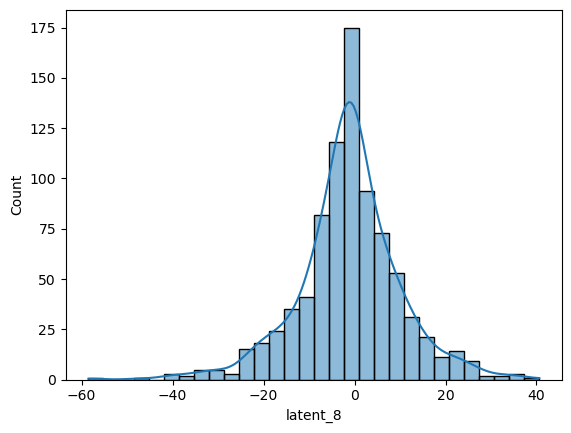

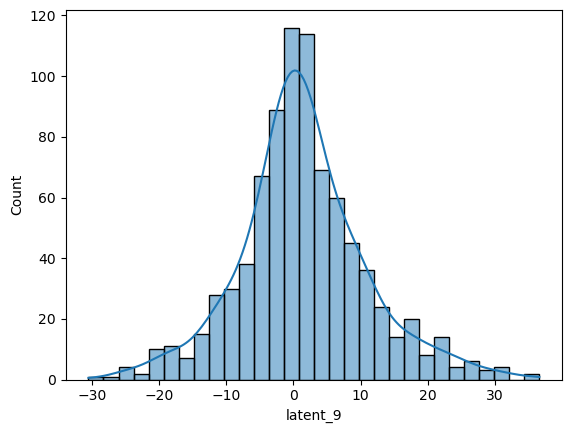

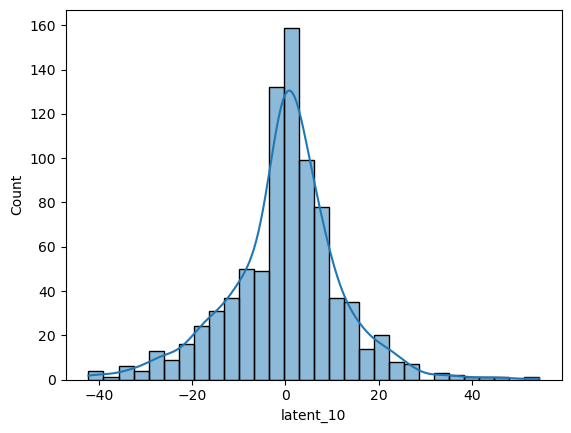

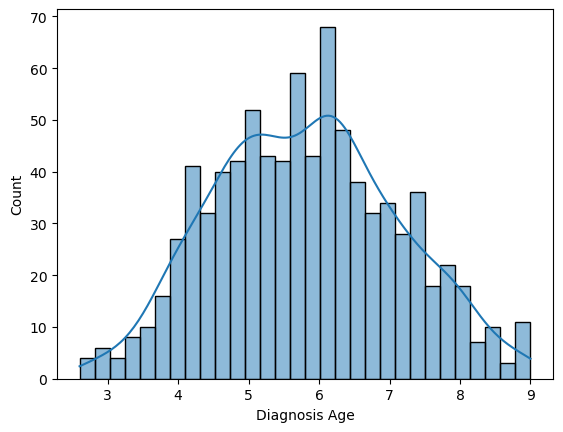

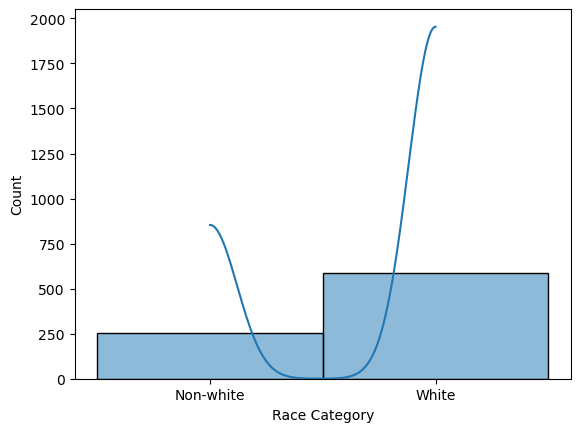

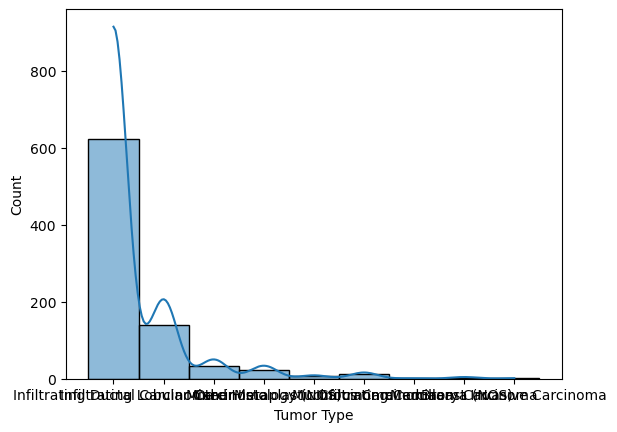

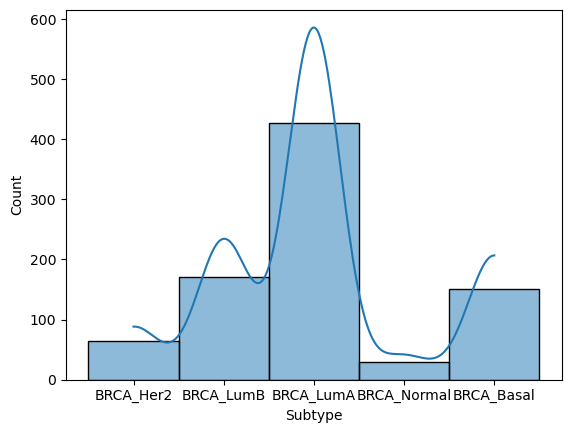

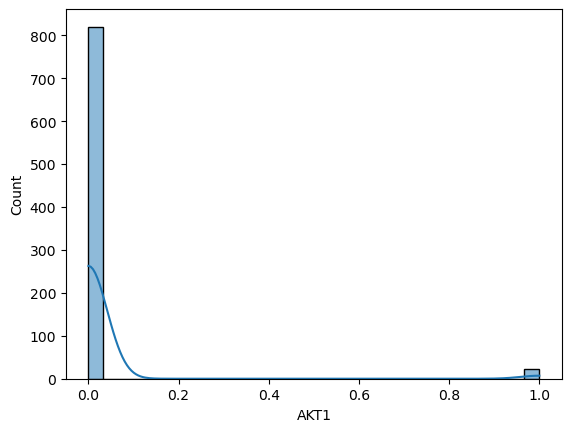

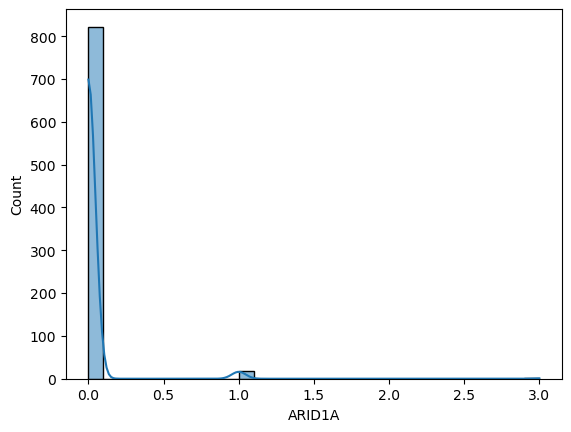

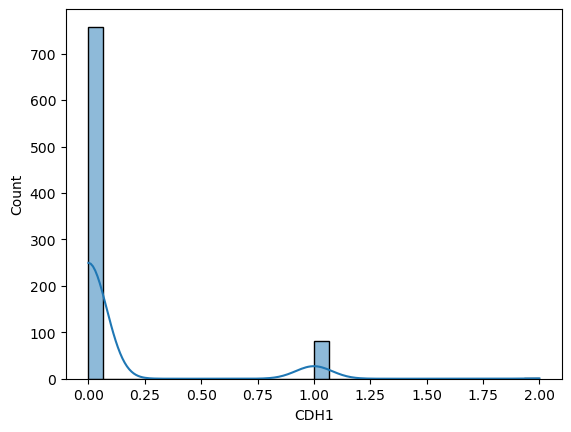

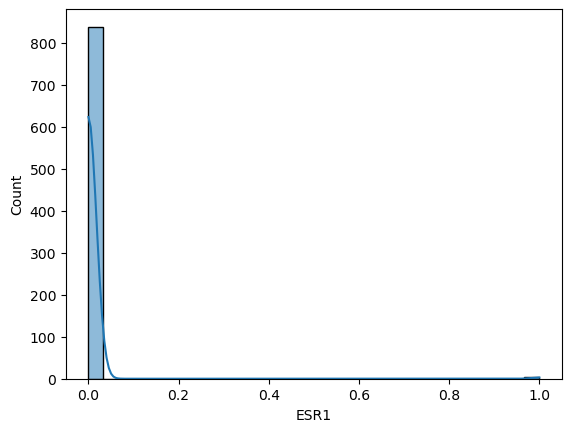

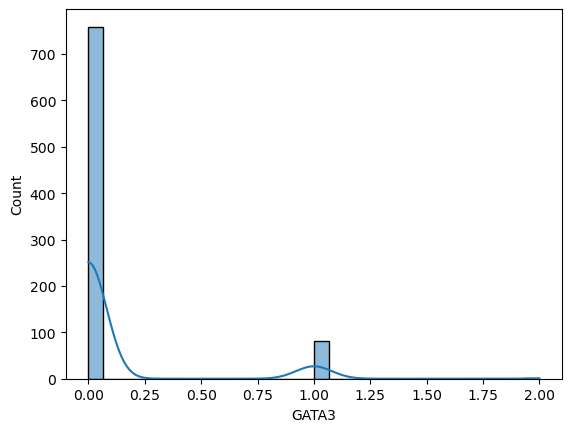

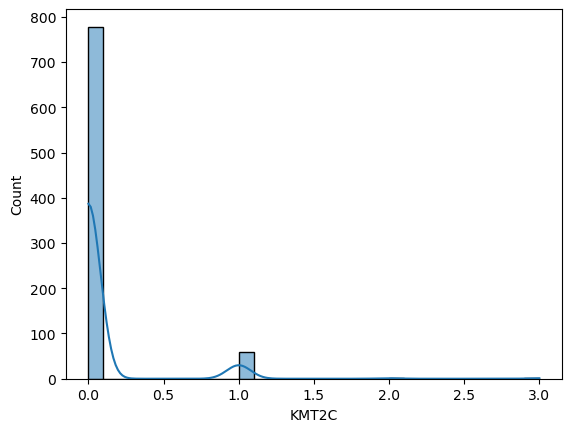

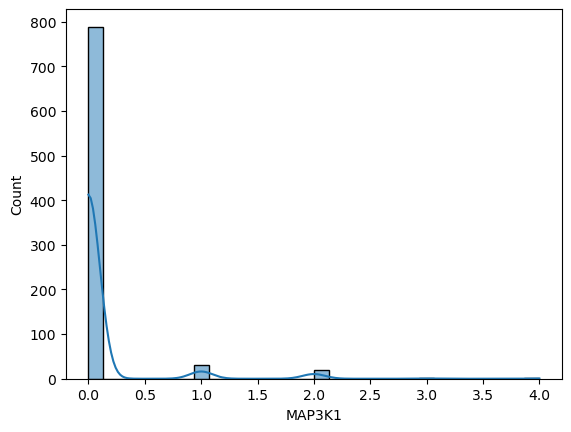

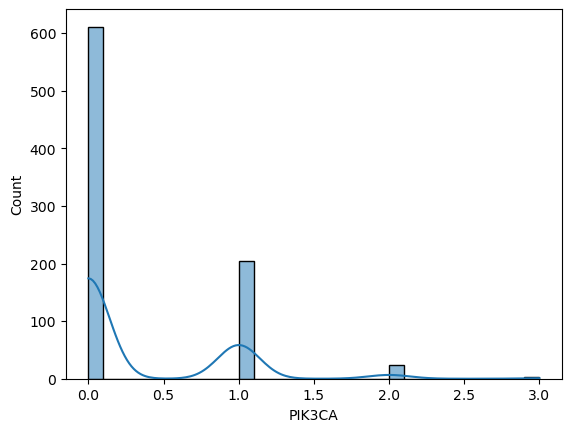

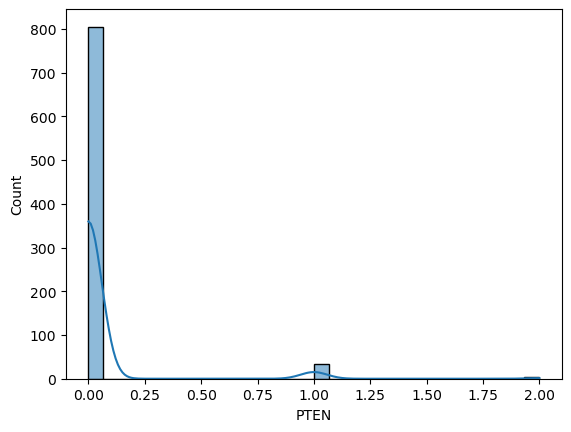

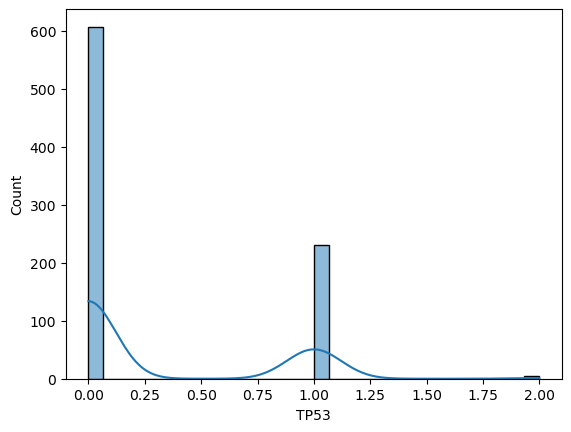

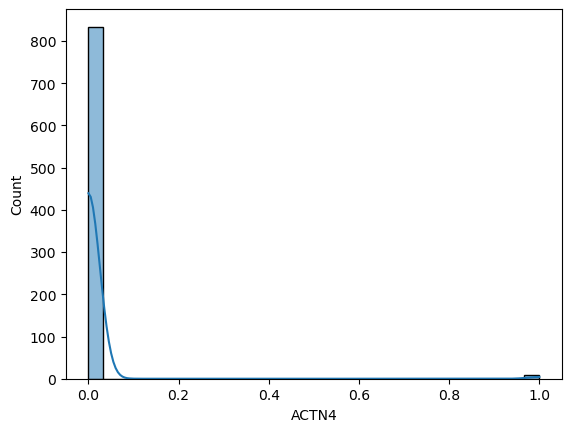

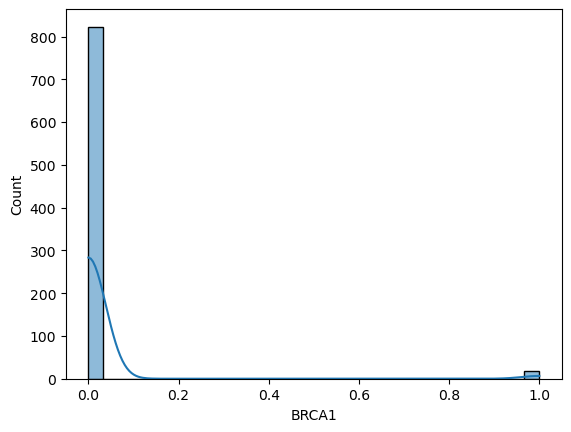

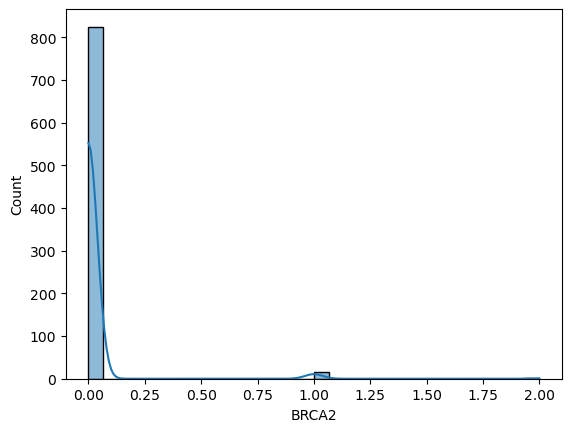

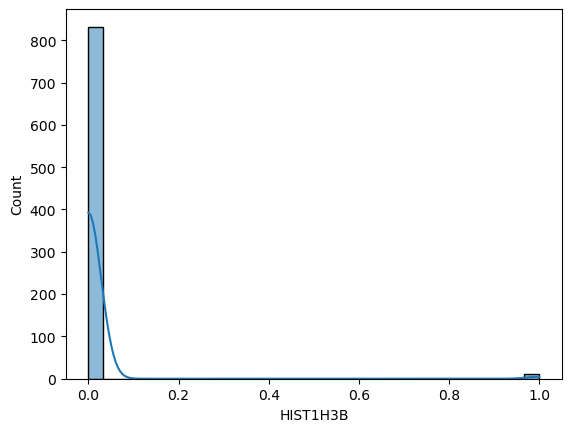

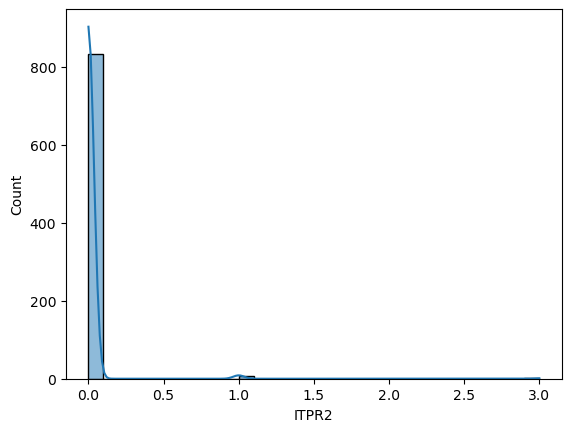

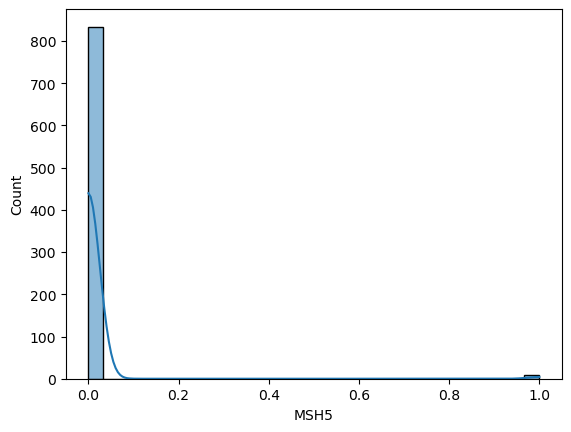

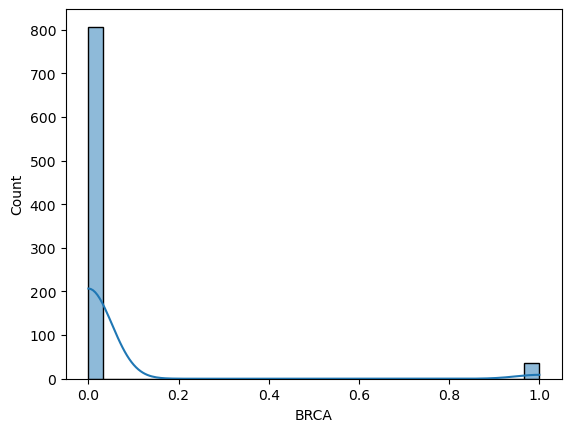

In [78]:
for col in X.columns:
    sns.histplot(X.loc[:,col], bins=30, kde=True)
    plt.show()

Text(0.5, 1.0, 'DFS > 5 years')

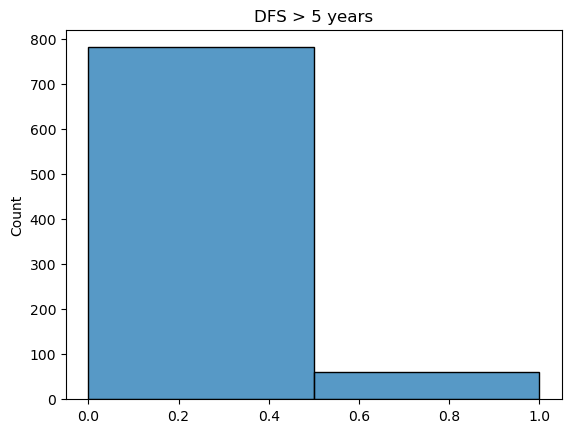

In [80]:
ax = sns.histplot(y, bins=2)
ax.set_title('DFS > 5 years')

<h1>Define filtering and evaluate models with 5-fold CV</h1>

In [82]:
categorical_cols = ['Subtype', 'BRCA', 'stage', 'Race Category']

def preprocessor(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    # One-hot encode categorical columns
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    # Optional: sort columns to ensure train/test consistency
    return X_encoded

def training_fold_filtering(X: pd.DataFrame, y: np.ndarray, k: int) -> tuple[pd.DataFrame, list[str]]:
    """
    Filtering logic should be implemented here. Then it will be applied to each cross validation training fold

    Takes in the DataFrame X and the list of target values y, applies filtering, and returns the filtered DataFrame and its column names (features)
        which will be used to subset the test fold data.

    Example filtering:
    1. Filter by mean expression
    2. Filter by variance
    3. Filter by within-class variance
    5. Select top k features using SelectKBest
    """
    X = DH.filter_genes_by_within_class_variance(X, y)

    if len(X.columns) < k:
        print(f"Warning: Less than {k} features after mean and variance filtering. Found {len(X.columns)} features.")
        print(f"Using all {len(X.columns)} features.")
        k = len(X.columns)

    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_genes = X.columns[selector.get_support()].tolist()
    return pd.DataFrame(X_new, columns=selected_genes, index=X.index), selected_genes

In [ ]:
# evaluate models with different number of features
results = {}
for k in range(1, 11):
    print(f"Evaluating models with top {k} features...")
    results[k] = evaluate_models(X, y, filter_data=training_fold_filtering, k=k, preprocess=preprocessor)

# find the top 4 models based on average of models' f1 score
f1_scores = []
result_k = []
for k, res in results.items():
    scores = []
    for name, model in res.items():
        scores.append(model['F1 Score']['global'])
    f1_scores.append(np.mean(scores))
    result_k.append(k)

# get the top 3 models
top_k = np.asarray(result_k)[np.argsort(f1_scores)[-3:][::-1]]

Evaluating models with top 1 features...
Evaluating models with top 2 features...
Evaluating models with top 3 features...
Evaluating models with top 4 features...
Evaluating models with top 5 features...
Evaluating models with top 6 features...
Evaluating models with top 7 features...
Evaluating models with top 8 features...
Evaluating models with top 9 features...
Evaluating models with top 10 features...


<h1>plot data</h1>

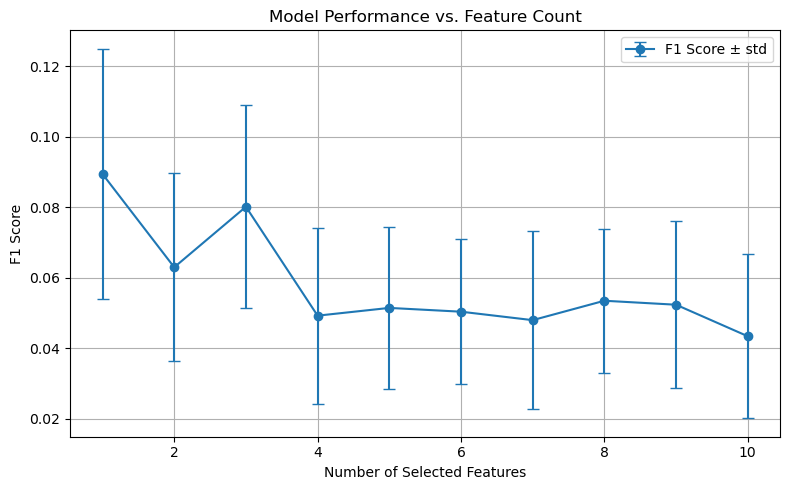

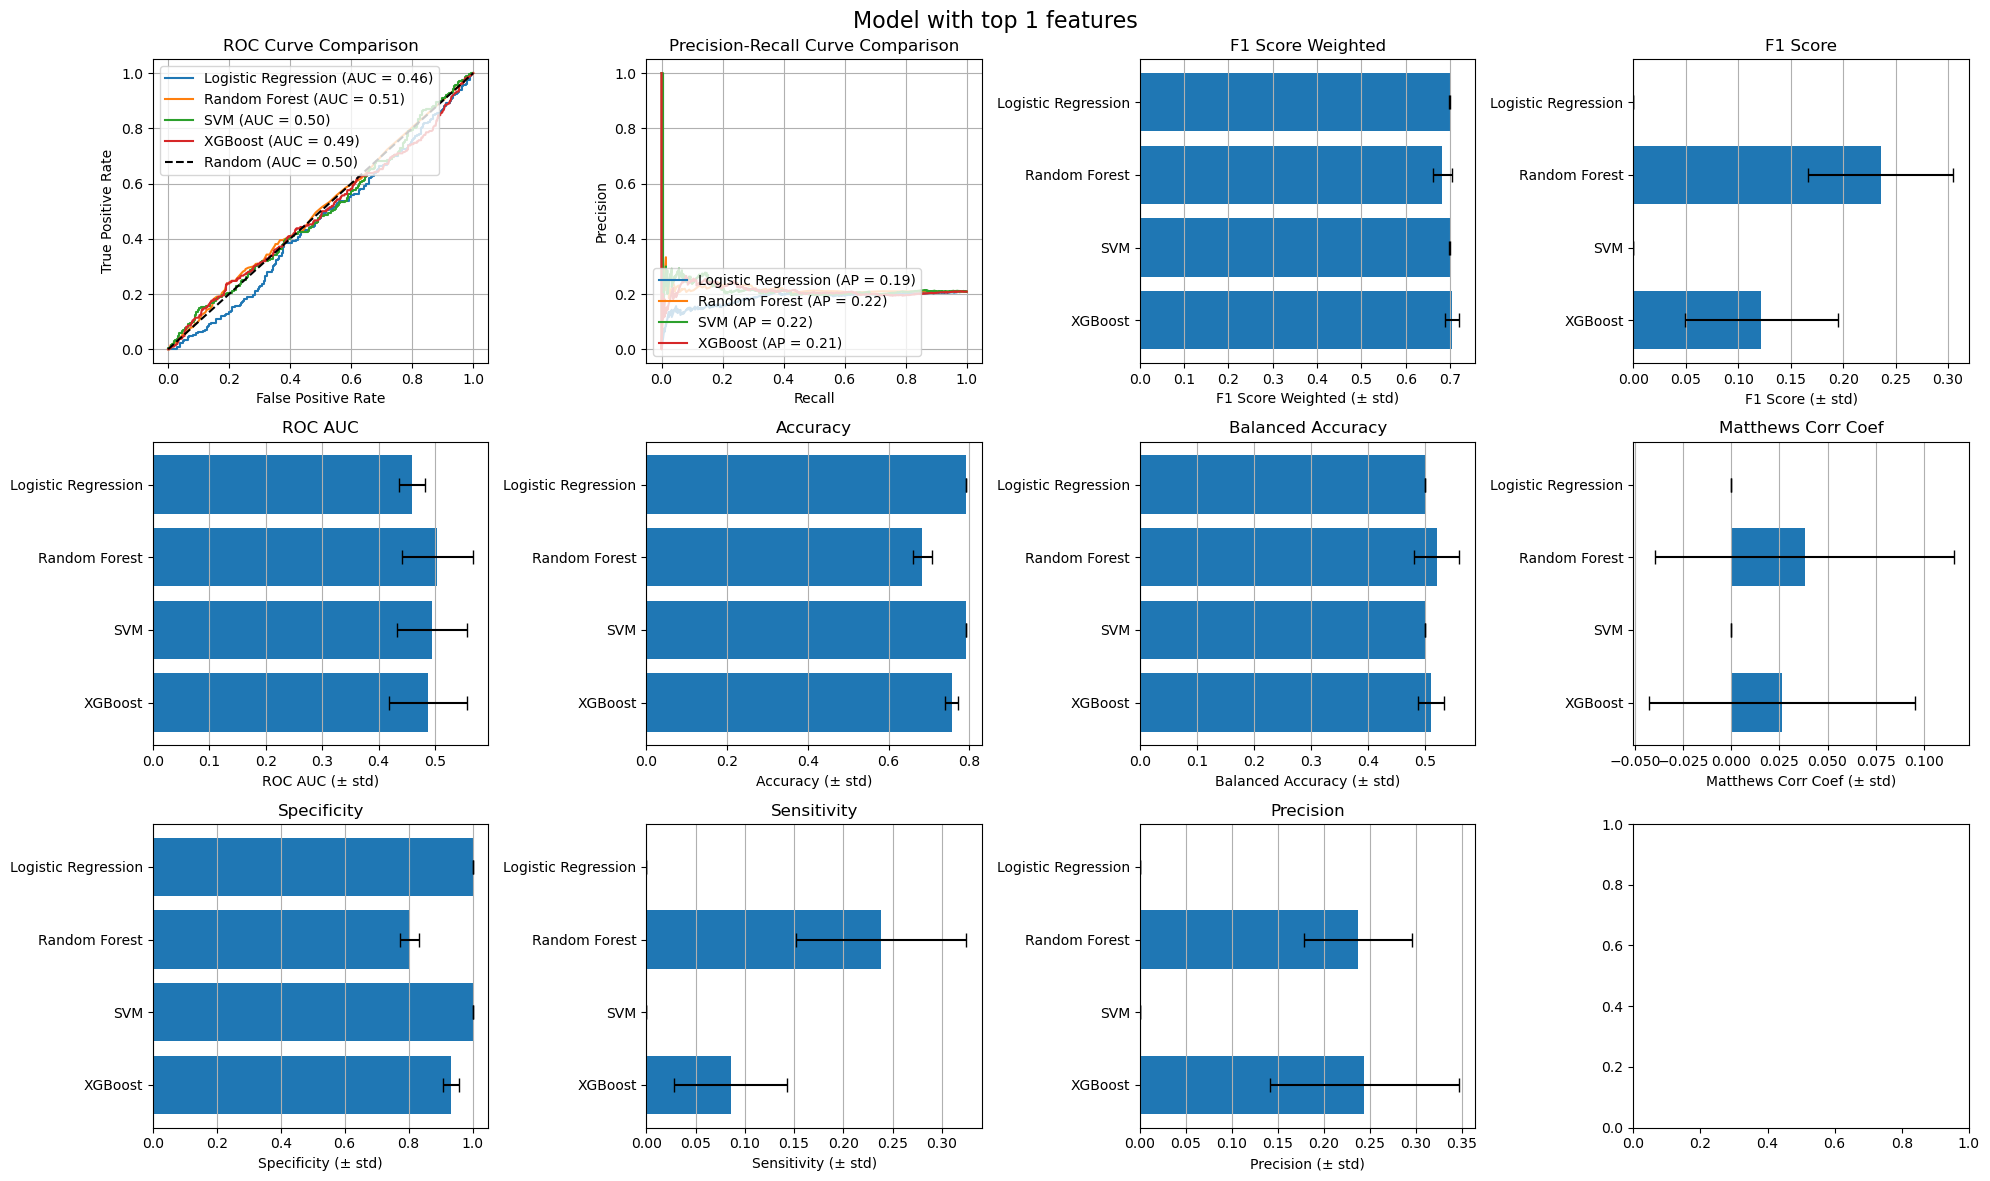

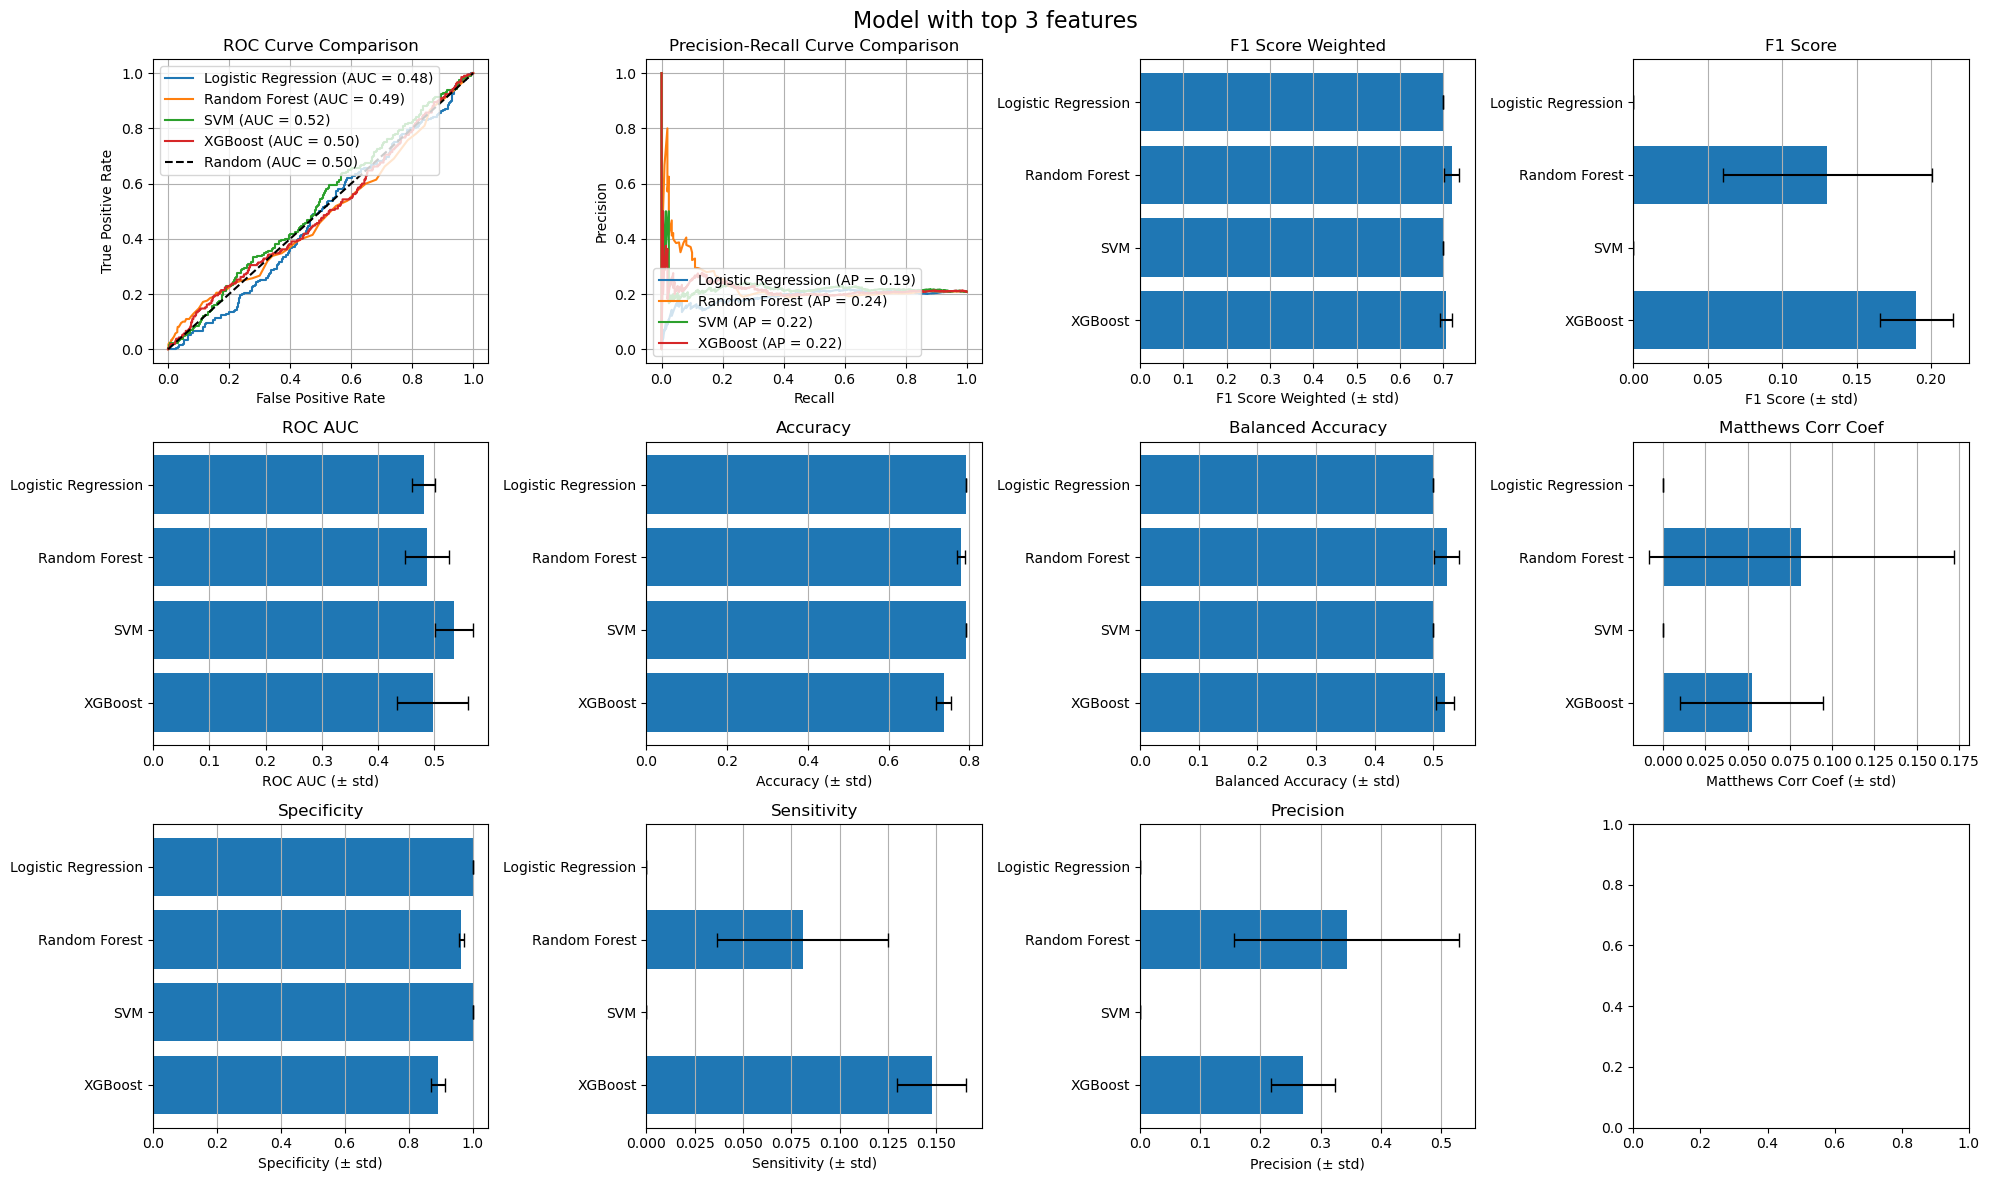

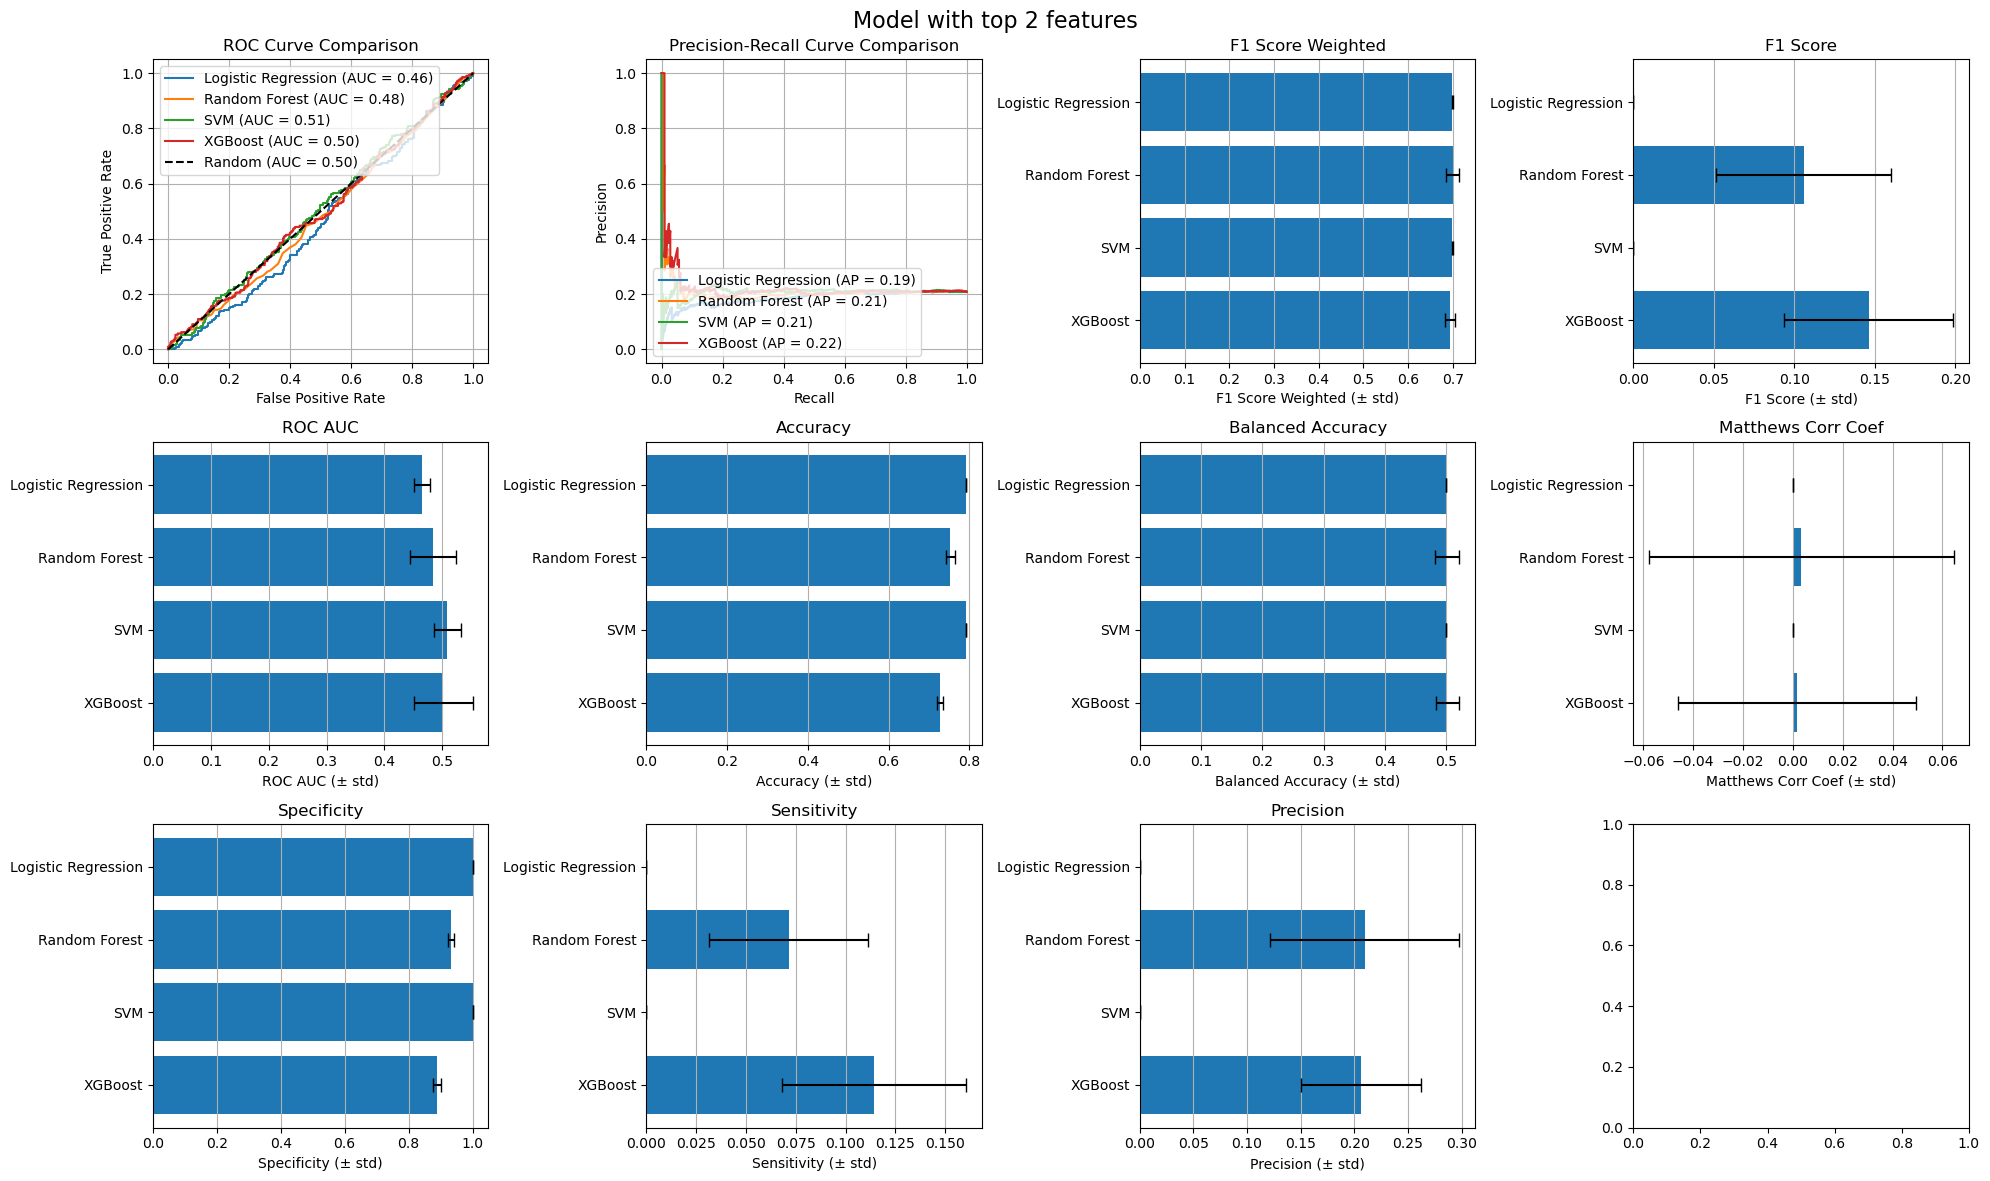

In [30]:
feature_counts, f1_means, f1_stds = [], [], []
for k, models in results.items():
    feature_counts.append(k)
    f1_means.append(np.mean([model['F1 Score']['mean'] for model in models.values()]))
    f1_stds.append(np.std([model['F1 Score']['std'] for model in models.values()]))
    
fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(feature_counts, f1_means, yerr=f1_stds, fmt='o-', capsize=4, label="F1 Score ± std")

ax.set_xlabel("Number of Selected Features")
ax.set_ylabel("F1 Score")
ax.set_title("Model Performance vs. Feature Count")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

for k in top_k:
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))

    plot_roc_curves(results[k], ax=axes[0, 0])
    plot_precision_recall_curves(results[k], ax=axes[0, 1])
    plot_classification_metric(results[k], ax=axes[0, 2], metric='F1 Score Weighted')
    plot_classification_metric(results[k], ax=axes[0, 3], metric='F1 Score')
    plot_classification_metric(results[k], ax=axes[1, 0], metric='ROC AUC')
    plot_classification_metric(results[k], ax=axes[1, 1], metric='Accuracy')
    plot_classification_metric(results[k], ax=axes[1, 2], metric='Balanced Accuracy')
    plot_classification_metric(results[k], ax=axes[1, 3], metric='Matthews Corr Coef')
    plot_classification_metric(results[k], ax=axes[2, 0], metric='Specificity')
    plot_classification_metric(results[k], ax=axes[2, 1], metric='Sensitivity')
    plot_classification_metric(results[k], ax=axes[2, 2], metric='Precision')
    fig.suptitle(f"Model with top {k} features", fontsize=16)
    fig.tight_layout()

<h1>Save results</h1>

In [14]:
timestamp = datetime.datetime.now().strftime("%m%d_%H-%M")
print(f"Timestamp: {timestamp}")

output=f'results/cv_results/latent_space_{timestamp}.pkl'

os.makedirs("results/cv_results", exist_ok=True)
with open(output, "wb") as f:
    pickle.dump(results, f)

print(f"Results saved to {output}")

Timestamp: 0607_13-09
Results saved to results/cv_results/latent_space_0607_13-09.pkl


<h1>Hyper param tune</h1>

Evaluating models with top 1 features...
Evaluating models with top 2 features...
Evaluating models with top 3 features...


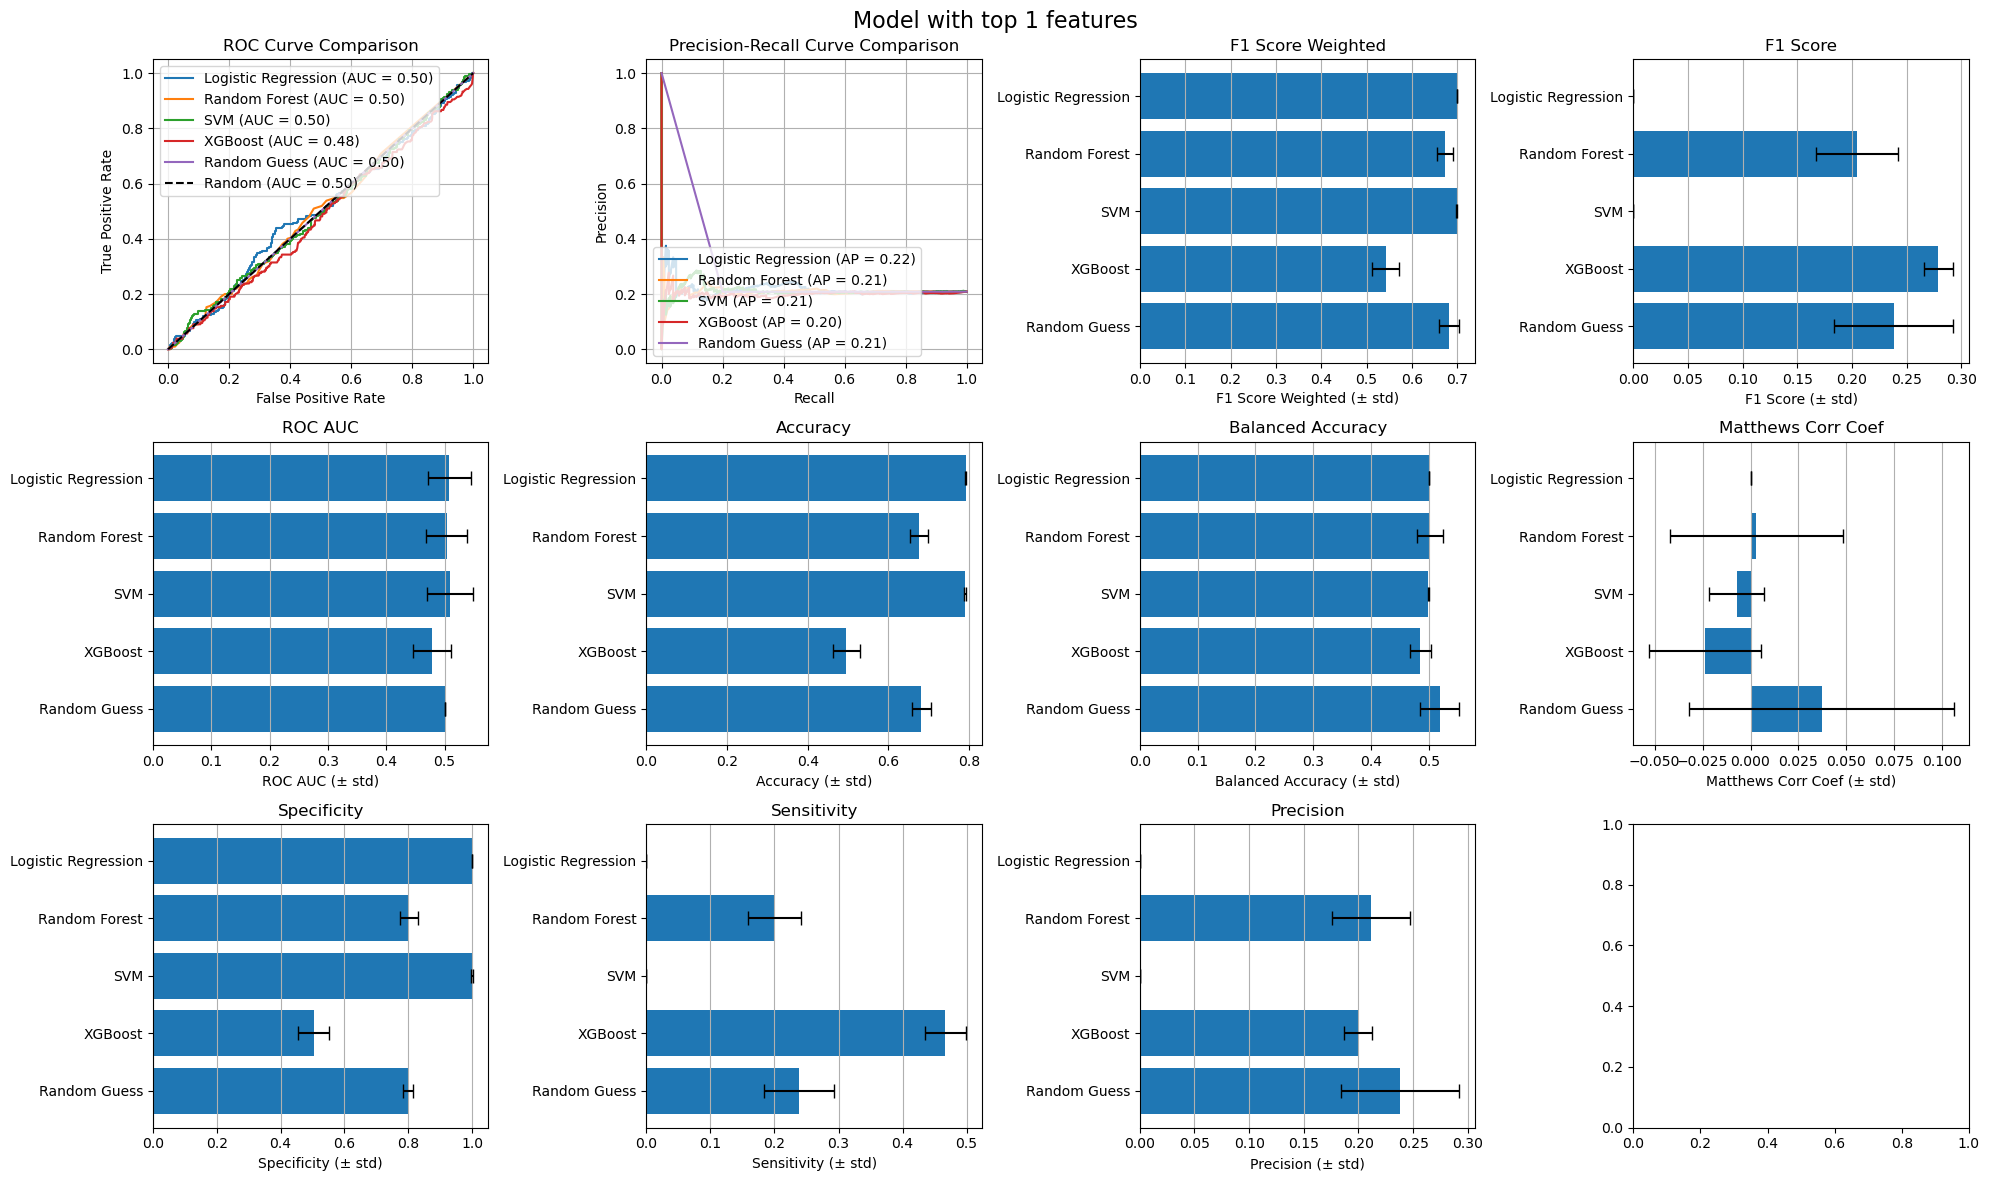

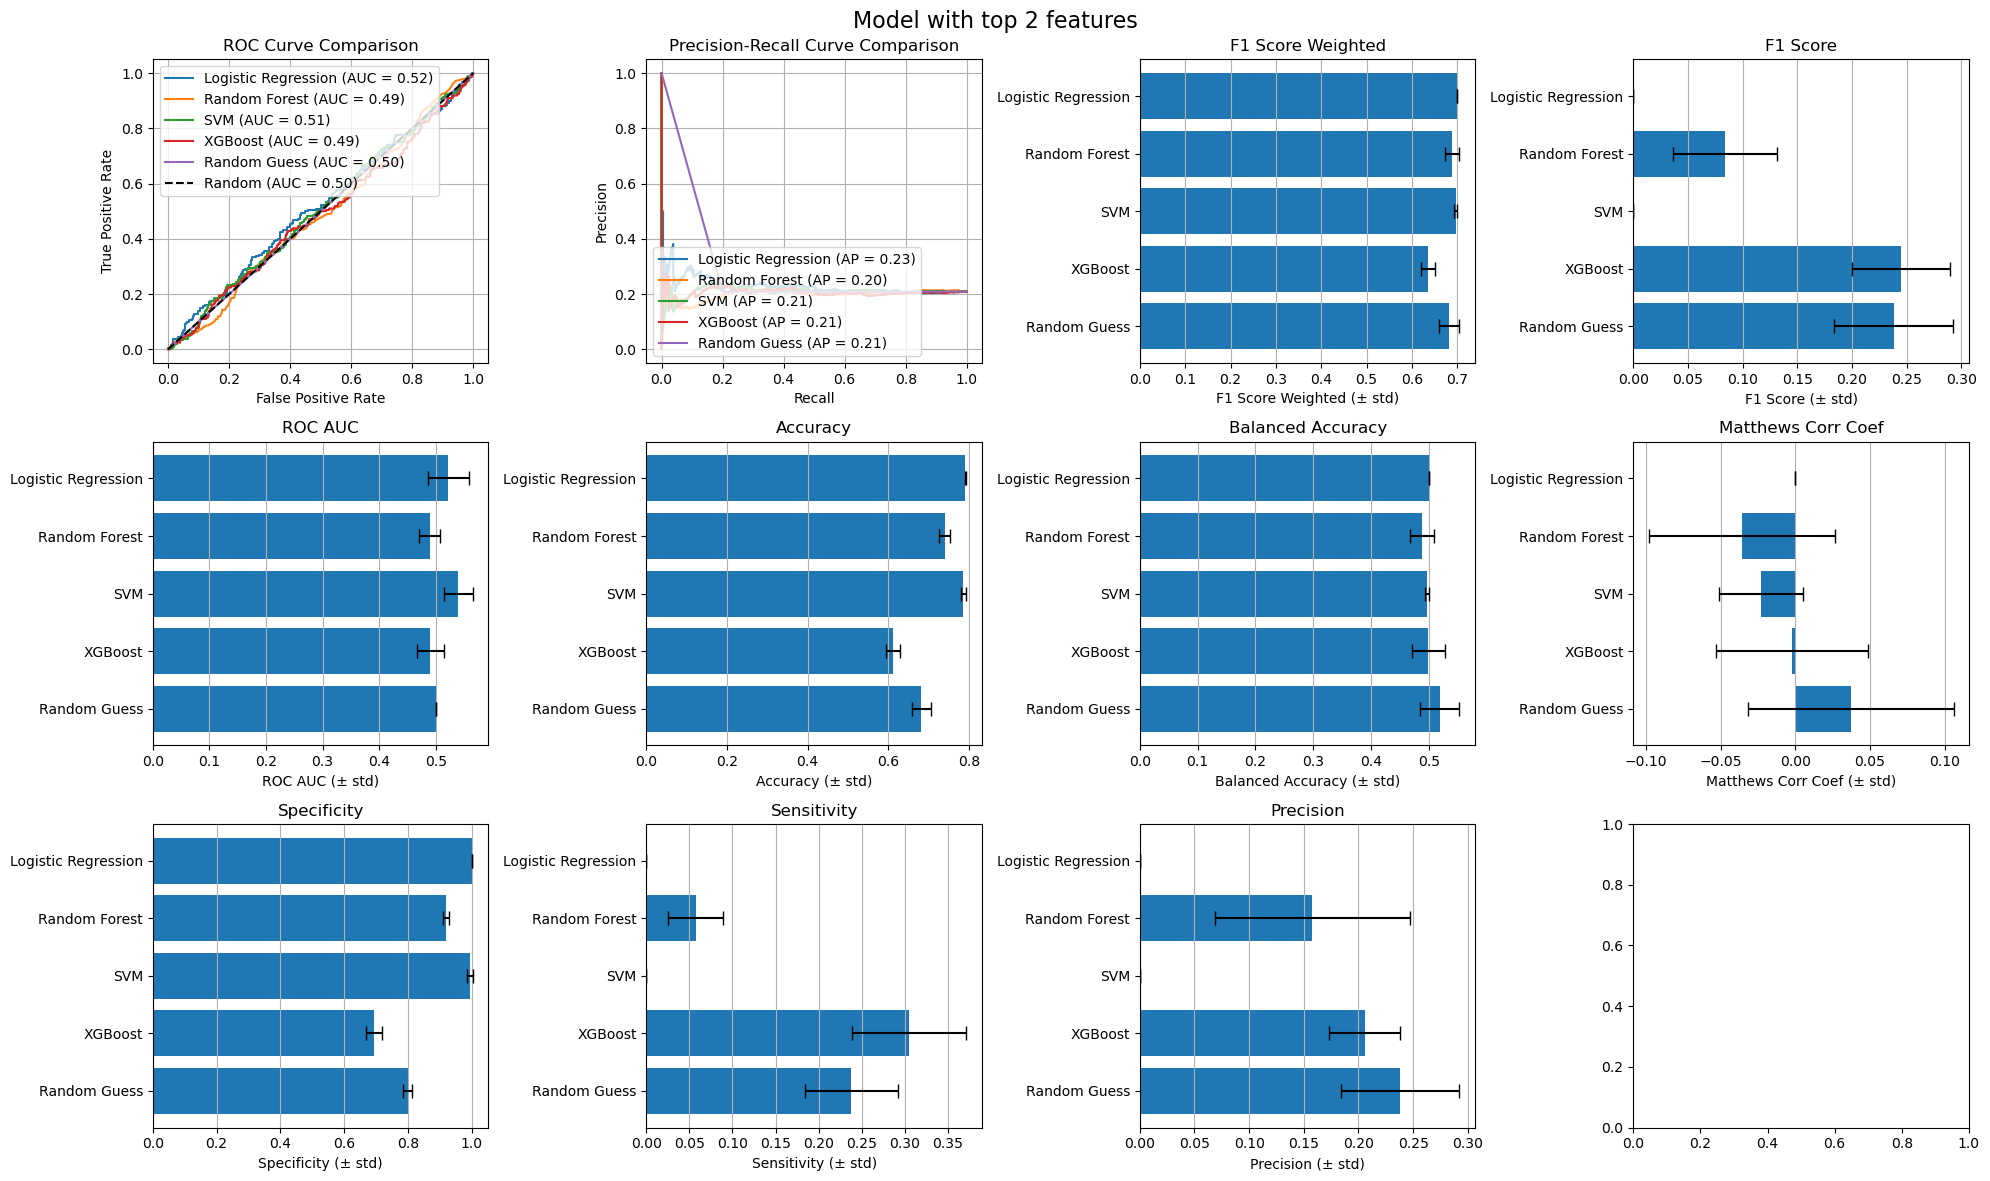

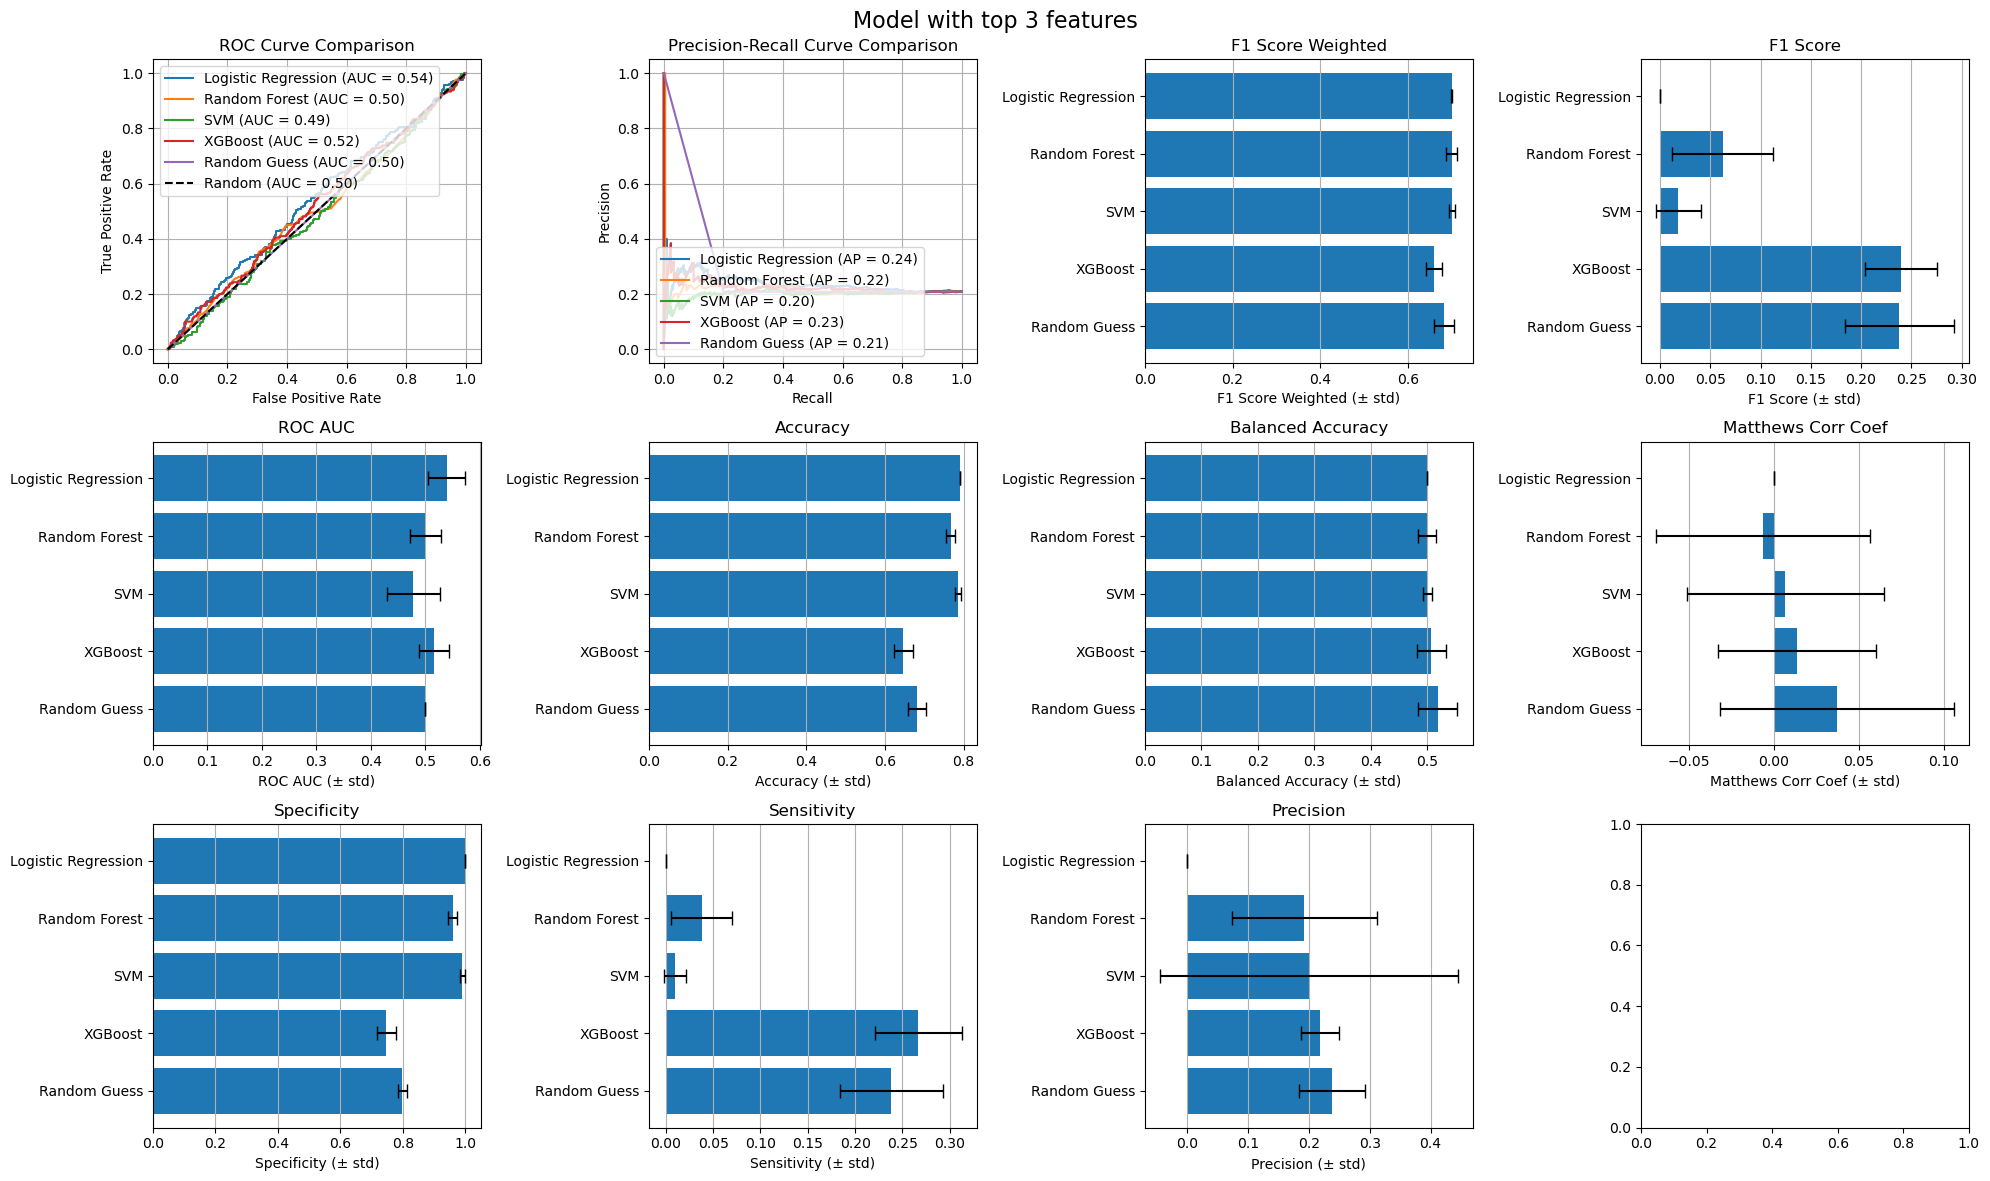

In [ ]:
# evaluate models with different number of features
results = {}
for k in top_k:
    print(f"Evaluating models with top {k} features...")
    results[k] = evaluate_models_nested(X, y, filter_data=training_fold_filtering, k=k, preprocess=preprocessor)

# find the top 4 models based on average of models' f1 score
f1_scores = []
result_k = []
for k, res in results.items():
    scores = []
    for name, model in res.items():
        scores.append(model['F1 Score']['global'])
    f1_scores.append(np.mean(scores))
    result_k.append(k)

# get the top 3 models
top_k = np.asarray(result_k)[np.argsort(f1_scores)[-3:][::-1]]

for k in top_k:
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))

    plot_roc_curves(results[k], ax=axes[0, 0])
    plot_precision_recall_curves(results[k], ax=axes[0, 1])
    plot_classification_metric(results[k], ax=axes[0, 2], metric='F1 Score Weighted')
    plot_classification_metric(results[k], ax=axes[0, 3], metric='F1 Score')
    plot_classification_metric(results[k], ax=axes[1, 0], metric='ROC AUC')
    plot_classification_metric(results[k], ax=axes[1, 1], metric='Accuracy')
    plot_classification_metric(results[k], ax=axes[1, 2], metric='Balanced Accuracy')
    plot_classification_metric(results[k], ax=axes[1, 3], metric='Matthews Corr Coef')
    plot_classification_metric(results[k], ax=axes[2, 0], metric='Specificity')
    plot_classification_metric(results[k], ax=axes[2, 1], metric='Sensitivity')
    plot_classification_metric(results[k], ax=axes[2, 2], metric='Precision')
    fig.suptitle(f"Model with top {k} features", fontsize=16)
    fig.tight_layout()

In [15]:
timestamp = datetime.datetime.now().strftime("%m%d_%H-%M")
print(f"Timestamp: {timestamp}")

output=f'results/cv_results/latent_space_nested_{timestamp}.pkl'

os.makedirs("results/cv_results", exist_ok=True)
with open(output, "wb") as f:
    pickle.dump(results, f)

print(f"Results saved to {output}")

Timestamp: 0607_14-18
Results saved to results/cv_results/latent_space_nested_0607_14-18.pkl
